In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
pandas.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pandas.set_option('display.width', 0)           # Désactive le wrap automatique
pandas.set_option('display.expand_frame_repr', False)  # Garde tout sur une ligne si possible
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import mfg_stats

In [4]:
import io_config

config = io_config.load_config('shipping_config.yaml')

save_fig = io_config.activate_save_fig(config)

# Get data

## Read data

In [5]:
save_concatenated_and_truncated_ts_in = config.outputs.timeseries.save_concatenated_and_truncated_ts_in

import pickle

with open(save_concatenated_and_truncated_ts_in, "rb") as f:
    print(f"reading from <{save_concatenated_and_truncated_ts_in}>...")
    daily_exports_imports_df = pickle.load(f)
daily_exports_imports_df

reading from <./data_out/all_from_to.pkl>...


country_from Indonesia                                              Australia                                                SAFR                            US                       Russia                                              Others                                   
country_to       Japan Vietnam    India South Korea   China  Others     Japan Vietnam   India South Korea   China  Others   India China Vietnam  Others   India  Japan China   Others  Japan Vietnam   India South Korea   China  Others   India   China Vietnam  Japan South Korea
Date                                                                                                                                                                                                                                                                               
2015-01-05      159706       0   851377      422752  650568  290053         0       0  293580      159706  460332  281836  722206     0       0  308845  240735      0     0   958239      0       0   23486       82202       0  135046   41101  463853   11743      0           0
2015-01-06           0   35221  1003801           0  631632  524795     79835       0  717217           0  563538       0  934536     0       0  343994   88053      0     0  1015539  23480       0       0      166714       0   93923   98618  119752   11740      0           0
2015-01-07           0   25300   407337      110056  258063  158127    110056       0  612267           0  164452   37950  183427     0       0  506003       0      0     0   585715      0       0       0      183427       0  151800   86021  180896       0      0           0
2015-01-08           0   39077   657804      104207  315224  240974    182362       0  566625      140679  677344  247490  514521     0       0  296989   97694      0     0   857101      0       0       0           0    7164   13024  200598   80759    3907      0      208414
2015-01-09           0   37359   336234       84682  143210  682433     62266       0  249064           0  261517  112078       0     0       0  165627  149438      0     0   371106      0       0       0      209213       0   18056   47322       0       0  59775           0
...                ...     ...      ...         ...     ...     ...       ...     ...     ...         ...     ...     ...     ...   ...     ...     ...     ...    ...   ...      ...    ...     ...     ...         ...     ...     ...     ...     ...     ...    ...         ...
2025-05-13       47000       0   813000           0  424001  886000    196000  682000  333000      220000  402998  530130  211000     0       0  220000   75000  68000     0   424000      0       0       0           0  245000  415850  150000   63000       0  70000       20000
2025-05-14      310000  200000   275000      136000  634001  356500    271000  165000   78000           0  598000  140000  439000     0       0  285000   50000      0     0   105000      0       0  236000       16000       0  180350  118000       0       0  75000           0
2025-05-15       50000   68000   378001           0  485000  574000    130000       0       0           0  580000  442000   68000     0       0  519000  155000      0     0   241000      0       0   75000       30000   95000  246950  171750   60000   48000  80000       29000
2025-05-16       91000   50000   341000           0       0  406000     80000       0   80000           0  410000       0   50000     0       0  100000       0      0     0    75000      0       0       0           0   53000   68000  588500       0       0  34000       40000
2025-05-17           0   50000    50000           0       0       0         0       0       0           0       0   80000       0     0       0       0       0      0     0    75000      0       0       0           0       0       0   30000       0       0      0           0

[3786 rows x 31 columns]

# Explore parameters

I need to find a stationary time interval and the correct average shits and averaging (nbe days) for the congestion.

In [6]:
from tqdm.notebook import tqdm

start_years = [2015, 2016, 2017, 2018]
end_years   = [2020, 2021, 2022, 2023]

shifts = [60, 30, 20]

formula_roll = lambda s: int(s/3)

if False:
    all_tests = []
    
    for shift in tqdm(shifts):
        # 1. prepare
        roll = formula_roll(shift)
        dataset = mfg_stats.prepare_data(
            daily_exports_imports_df, drop_others='Others', shift=-shift, roll=roll
        )
        for y_start in tqdm(start_years, leave=False):
            for y_end in tqdm(end_years, leave=False):
                # 2. cut and regress
                date_from = f'{y_start}-06-01'
                date_to   = f'{y_end}-02-01'
                regression_df = mfg_stats.panel_of_regressions(
                    dataset, date_from=date_from, date_to=date_to, verbose=False)
    
                # 3. clean and count negative B
                same_B_df, renamed_df = mfg_stats.mark_same_country(regression_df)
                
                all_tests.append({
                    'shift'      : shift  , 
                    'roll'       : roll, 
                    'y_start'    : y_start, 
                    'y_end'      : y_end,
                    'nbe_rows'   : same_B_df.shape[0],
                    'avg_B'      : same_B_df.same_B_as_country_to.mean(),
                    'nbe_finite' : np.isfinite(same_B_df.same_B_as_country_to).mean(),
                    'nbe_neg'    : (same_B_df.same_B_as_country_to<=0).mean(),
                    'regression_df': regression_df,
                })

    # 4. display
    all_tests_df = pandas.DataFrame(all_tests)
    print(all_tests_df.drop(columns=['regression_df']).sort_values(by='nbe_neg', ascending=False).head(5))
    print('')
    # 5. display
    reg0_df = all_tests_df.sort_values(by='nbe_neg', ascending=False).iloc[0,:].regression_df
    same_B_df, renamed_df = mfg_stats.mark_same_country(reg0_df)
    print(same_B_df.sort_values(by='same_B_as_country_to', ascending=True))

## Results of the explorations

<pre>
    shift  roll  y_start  y_end  nbe_rows  nbe_finite  nbe_neg
24     30    10     2017   2020        25        0.84     0.44
28     30    10     2018   2020        25        0.84     0.32
13     60    20     2018   2021        25        0.84     0.32
44     20     6     2018   2020        25        0.84     0.32
8      60    20     2017   2020        25        0.84     0.32
</pre>

**Regression coefs**

<pre>
   country_from   country_to  same_B_as_country_to
8     Indonesia  South Korea             -0.051434
13       Russia  South Korea             -0.041828
12       Russia        Japan             -0.036956
7     Indonesia        Japan             -0.018132
0     Australia        China             -0.007467
16         SAFR        India             -0.002395
20           US        China             -0.002178
21           US        India             -0.002170
15         SAFR        China             -0.001612
3     Australia  South Korea             -0.001458
22           US        Japan             -0.000271
10       Russia        China              0.008115    
</pre>

# Restart the full process and study

In [7]:
shift = config.config.best_avg_params.shift
roll   = config.config.best_avg_params.roll
date_from = f'{config.config.best_avg_params.year_start}-06-01'
date_to   = f'{config.config.best_avg_params.year_end}-02-01'

config.config.best_avg_params._asdict()

{'shift': 60, 'roll': 20, 'year_start': 2018, 'year_end': 2021}

## Step 0+1: load and prepare data

In [8]:
stat_container = mfg_stats.MFGStatContainer(daily_exports_imports_df)

dataset = stat_container.prepare_dataset(shift=-shift, roll=roll, drop_others='Others')

image ./images/select_stationary_congestion.pdf exists, use force=True to replace


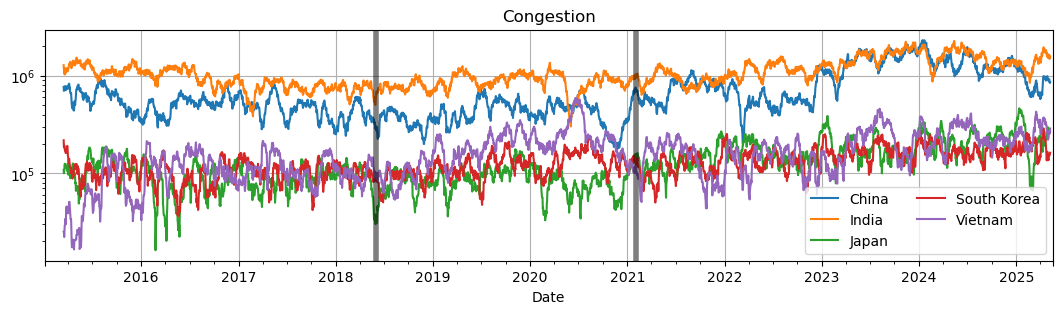

In [9]:
dataset.phi_point.plot(figsize=(13,3), grid=True, logy=True, title='Congestion')
plt.axvline(pandas.Timestamp(date_from),color='k', lw=4, alpha=.5)
plt.axvline(pandas.Timestamp(date_to  ),color='k', lw=4, alpha=.5)
plt.legend(ncols=2)

save_fig('select_stationary_congestion')

# All regressions

The formula

\begin{alignat}{3}\nonumber
    \textcolor{orange}{Q^n_{i,j}} \textcolor{violet}{\varphi^n_{i,\cdot}} &= %w^n_{i,j}\; \frakM^n_{i,j} - w^n_{i,j} r_j\, \textcolor{violet}{\varphi^{\cdot}_{\ell,\cdot}} + \sum_\ell w^n_{i,j} {w^n_{i,\ell}\over \sum_{\ell'} w^n_{i,\ell'}} r_\ell \textcolor{violet}{\varphi^{\cdot}_{\ell,\cdot}}\\
    w^n_{i,j}\; {\frak M}^n_{i,j} &+& \sum_{\ell} w^n_{i,j}\left( {w^n_{i,\ell}\over \sum_{\ell'} w^n_{i,\ell'}} - \mathbb{1}_{j=\ell}\right) r_\ell\; &\textcolor{violet}{\varphi^{\cdot}_{\ell,\cdot}}\\
    \label{eq:prelinreg} &= A^n_{i,j} &+& \sum_\ell B^n_{i,j,\ell} &\textcolor{violet}{\varphi^{\cdot}_{\ell,\cdot}}.
\end{alignat}

The first term comes from the margin: **export more** towards destinations you can get money from, but it is renormalized by the "*average possible margin*".

The second terme comes from the congestion costs: **export less** towards this destination (when they are a lot of other ships) but only in comparison with the *average congestion*.

The last term says something about the $B^n_{i,j,\ell}$ they should be comparable for destinations that are not the considered ones.

## Step 2: post-process

In [10]:
# isolating stationary interval
stat_container.regress_and_postprocess(date_from=date_from, date_to=date_to)

regression_df = stat_container.regression_df

export_countries: ['Australia', 'Indonesia', 'Russia', 'SAFR', 'US']
import_countries: ['China', 'India', 'Japan', 'South Korea', 'Vietnam']
... Japan is not in importing from SAFR
... South Korea is not in importing from SAFR
... South Korea is not in importing from US
... Vietnam is not in importing from US


In [11]:
# the results are no more the same than the ones during the intership
# (probably due to the train/test random split)
regression_df[regression_df.country_from=='Indonesia'].sort_values(by='const')

,country_from,country_to,const,phi_point_China,phi_point_India,phi_point_Japan,phi_point_South Korea,phi_point_Vietnam,residuals
9,Indonesia,Vietnam,-20894.791389,0.088438,0.046166,-0.005530,0.103416,0.041957,225420.174915
7,Indonesia,Japan,24056.097097,0.000845,0.006423,0.015984,-0.089406,0.004952,41904.910001
8,Indonesia,South Korea,42270.276195,-0.008534,-0.013298,0.111327,-0.037818,-0.011849,47027.966163
5,Indonesia,China,273369.206078,0.001403,0.127569,-0.488745,-0.624674,0.015170,393068.875653
6,Indonesia,India,333976.393532,-0.040650,-0.044671,0.840579,0.264416,-0.039073,274908.946068


In [12]:
regression_df.pivot(index='country_to', columns='country_from', values='const')

country_from,Australia,Indonesia,Russia,SAFR,US
country_to,,,,,
China,-21331.026514,273369.206078,19676.400945,5154.987243,6509.724281
India,195305.672467,333976.393532,5616.864825,93400.812749,45661.649052
Japan,30239.768109,24056.097097,5787.470701,NaN,9589.197406
South Korea,-1538.823684,42270.276195,33787.468256,NaN,NaN
Vietnam,-38075.157469,-20894.791389,7185.025656,-54014.933741,NaN


## Compare constants

In [13]:
# the reference is the total import
total_exports_df = (
    dataset.from_to[date_from:date_to]
    .mean(axis=0).unstack().T
    .drop(columns=['Others'], index=['Others'])
)
total_exports_df

country_from,Australia,Indonesia,Russia,SAFR,US
country_to,,,,,
China,49010.385875,268204.886387,41518.700102,1804.402252,3647.205732
India,185605.237462,373792.825998,33882.813715,115337.612078,53178.666325
Japan,27643.384852,21361.014330,15165.664278,NaN,4289.036847
South Korea,14547.529171,29533.073695,42325.071648,NaN,NaN
Vietnam,64725.453429,76773.693961,13178.996929,22966.806551,NaN


image ./images/compare_Aij.pdf exists, use force=True to replace


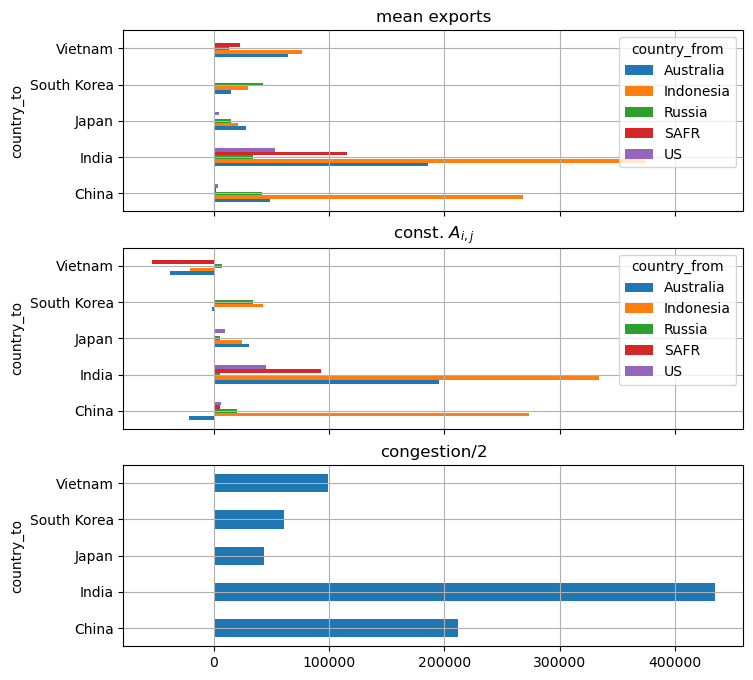

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(8,8), nrows=3, sharex=True)

total_exports_df.plot(
    kind='barh', logx=False, grid=True, ax=ax1, title='mean exports',
)

regression_df.pivot(index='country_to', columns='country_from', values='const').plot(
    kind='barh', logx=False, grid=True, ax=ax2, title='const. $A_{i,j}$',
)

(dataset.phi_point[date_from:date_to].mean()/2).rename('congestion').plot(
    kind='barh', logx=False, grid=True, ax=ax3, title='congestion/2'
)

save_fig('compare_Aij')

In [15]:
(
    regression_df.pivot(index='country_to', columns='country_from', values='const') /
    total_exports_df
)

country_from,Australia,Indonesia,Russia,SAFR,US
country_to,,,,,
China,-0.435235,1.019255,0.473917,2.856895,1.784853
India,1.052264,0.893480,0.165773,0.809804,0.858646
Japan,1.093924,1.126168,0.381617,NaN,2.235746
South Korea,-0.105779,1.431286,0.798285,NaN,NaN
Vietnam,-0.588256,-0.272161,0.545188,-2.351870,NaN


## Understanding the B coefs

In [16]:
same_B_df  = stat_container.same_B_df
renamed_df = stat_container.renamed_df

nbe_finite = (np.isfinite(same_B_df.same_B_as_country_to)).sum()
nbe_neg    = (same_B_df.same_B_as_country_to<=0).sum()

print(f"{nbe_neg} negative terms over {nbe_finite} coefs")
print(f"avg  value is {same_B_df.same_B_as_country_to.mean():+5.3f}")
print(f"avg neg value {same_B_df.same_B_as_country_to[same_B_df.same_B_as_country_to<0].mean():+5.3f}")
print(f"avg pos value {same_B_df.same_B_as_country_to[same_B_df.same_B_as_country_to>0].mean():+5.3f}")

same_B_df.sort_values(by='same_B_as_country_to', ascending=True).sample(7)

9 negative terms over 21 coefs
avg  value is +0.015
avg neg value -0.030
avg pos value +0.048


,country_from,country_to,same_B_as_country_to
13,Russia,South Korea,-0.051034
9,Indonesia,Vietnam,0.041957
14,Russia,Vietnam,0.012356
0,Australia,China,0.101141
6,Indonesia,India,-0.044671
8,Indonesia,South Korea,-0.037818
3,Australia,South Korea,0.031076


image ./images/comment_Bij.pdf exists, use force=True to replace


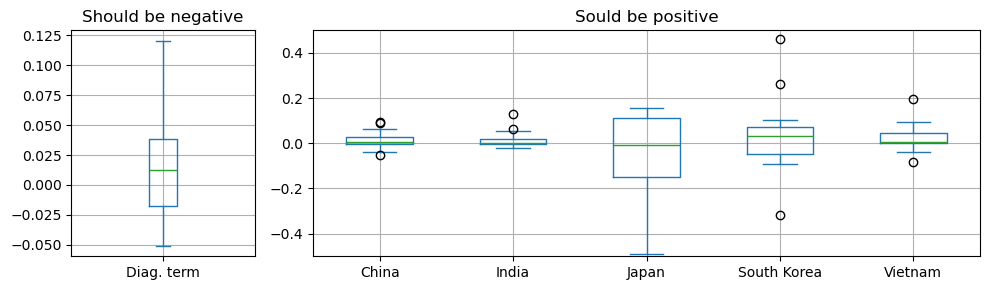

In [17]:
f = plt.figure(figsize=(10,3))

ax1 = plt.subplot2grid((1, 4), (0, 0))
# 1. the diagonal term `same_B_as_country_to` should be negative
(
    same_B_df.sort_values(by='same_B_as_country_to', ascending=True)
    .dropna().same_B_as_country_to.rename('Diag. term')
    .plot(kind='box', ax=ax1, grid=True, title='Should be negative')
)

ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=3)
# 2. the non diagonals should be close for the other countries
B_df = renamed_df[[c for c in renamed_df.columns if (isinstance(c, tuple) and c[1]=='B')]]
B_df = B_df.rename(columns={c: c[0] for c in B_df.columns})
T_df = renamed_df[[c for c in renamed_df.columns if (isinstance(c, tuple) and c[1]=='dest')]]
T_df = T_df.rename(columns={c: c[0] for c in T_df.columns})
B_others_df = B_df.mask(T_df)
B_others_df.plot(kind='box', ax=ax2, grid=True, ylim=(-.5,.5), title='Sould be positive')

plt.tight_layout()

save_fig('comment_Bij')

### Comment on positive $B_0$

when a coef is nevertheless positive, it means that congestion (proxied by the future traffic) is not (historically) happening in conjunction with less ships sent, but more ships.

It may be explained by a correlection between current shipping and congestion.

In [18]:
this_dataset = mfg_stats.slice_of(dataset, date_from=date_from, date_to=date_to)

correlations_lst = []

for colname in this_dataset.from_to.columns:
    if isinstance(colname, tuple):
        country_from = colname[0]
        country_to   = colname[1]
        if country_from=='Others' or country_to=='Others':
            continue
        
        Qphi      = this_dataset.from_to[(country_from, country_to)]
        phi_point = this_dataset.phi_point[country_to]

        correlations_lst.append({
            'country_from': country_from,
            'country_to': country_to,
            'date_from': date_from,
            'date_to': date_to,
            'corr': Qphi.corr(phi_point),
        })
        
corr_and_B0_df = pandas.merge(
    pandas.DataFrame(correlations_lst), same_B_df,
    left_on=['country_from', 'country_to'], right_on=['country_from', 'country_to'])
corr_and_B0_df.sample(7)     

,country_from,country_to,date_from,date_to,corr,same_B_as_country_to
9,Australia,China,2018-06-01,2021-02-01,0.169320,0.101141
0,Indonesia,Japan,2018-06-01,2021-02-01,-0.007986,0.015984
17,Russia,Vietnam,2018-06-01,2021-02-01,0.062317,0.012356
11,SAFR,China,2018-06-01,2021-02-01,-0.005673,-0.002837
2,Indonesia,India,2018-06-01,2021-02-01,-0.019522,-0.044671
19,Russia,South Korea,2018-06-01,2021-02-01,0.033165,-0.051034
3,Indonesia,South Korea,2018-06-01,2021-02-01,-0.043184,-0.037818


image ./images/B0_correl_flows.pdf exists, use force=True to replace


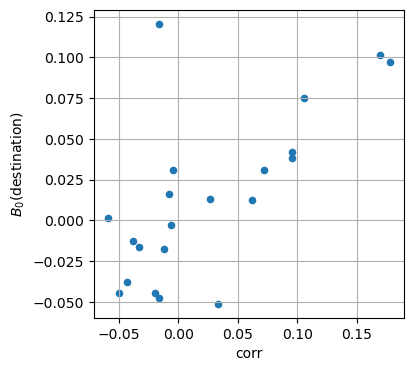

In [19]:
corr_and_B0_df.plot(
    kind='scatter', figsize=(4,4), grid=True,
    x='corr', y='same_B_as_country_to', 
)
plt.ylabel('$B_0$(destination)')

save_fig('B0_correl_flows')

# Add distance from pre-computed file



In [20]:
regression_and_distances_df = stat_container.concat_distances(
    config.outputs.ports.final.output_distances_countries_file
    )

In [21]:
all_distances_df = stat_container.all_distances_df
all_distances_df[all_distances_df.c1=='Australia']

,c1,c2,distKM_num
0,Australia,China,8156.224375
1,Australia,SAFR,10828.064062
48,Australia,India,9262.251375
56,Australia,Indonesia,5669.357250
65,Australia,Japan,8047.952250
72,Australia,Russia,17972.271125
78,Australia,South Korea,8279.180417
81,Australia,US,19388.028125
86,Australia,Vietnam,7120.734250


In [22]:
regression_and_distances_df.sample(7)

,distKM_num,country_from,country_to,const,"(China, B)","(India, B)","(Japan, B)","(South Korea, B)","(Vietnam, B)",residuals,"(China, dest)","(India, dest)","(Japan, dest)","(South Korea, dest)","(Vietnam, dest)"
14,14505.013300,Russia,Vietnam,7185.025656,0.008255,0.001370,-0.051528,0.028262,0.012356,35285.513447,False,False,False,False,True
20,18889.493600,US,China,6509.724281,-0.017495,0.000835,-0.023964,0.045684,-0.001307,33409.574875,True,False,False,False,False
13,15666.217333,Russia,South Korea,33787.468256,0.042315,0.005372,-0.226932,-0.051034,0.061196,123087.288817,False,False,False,True,False
11,13014.139900,Russia,India,5616.864825,-0.002563,0.013028,0.053509,0.034794,0.044718,79115.035541,False,True,False,False,False
16,8630.010375,SAFR,India,93400.812749,0.020559,0.030796,-0.151210,-0.317993,0.194523,219629.735267,False,True,False,False,False
5,4857.403600,Indonesia,China,273369.206078,0.001403,0.127569,-0.488745,-0.624674,0.015170,393068.875653,True,False,False,False,False
6,4537.691200,Indonesia,India,333976.393532,-0.040650,-0.044671,0.840579,0.264416,-0.039073,274908.946068,False,True,False,False,False


## Save results

In [23]:
save_coef_and_distances_in = config.outputs.regression.coef_and_distances
with open(save_coef_and_distances_in, "wb") as f:
    pickle.dump(regression_and_distances_df, f)